### So the first part of this project is extracting data from the dataset
 

### PROBLEM STATEMENT 
1. We are part of a company called SECOND CARS and we sell used cards.
2. During a recent company survey it was observed that cars belonging to 'chevrolet' are not priced correctly by the sellers. Some of the cars are way overpriced and some of the cars are way under priced which has caused substantial loss in the previous quarter.
3. To remedy this the senior management has tasked us to create a model which will efficiently predict the price of cars with minimum error. So that it will be helpful to the sales people to correctly price the car.
4. They have also asked us to prepare a decision tree for the sellers who want to also use their own intuition combined with the model.
5. They have asked us to create interactive dashboards for our sellers with non technical background.
6. They have also asked us to create a RESTful API which will be used by IT departments of our other clients programmatically to get the pricing.


### Objectives 
1. Company Data is in a SQLite database. So We need to extract rows only belonging to  'Chevrolet'.
2. Convert Data into a pandas DataFrame.
3. Train the machine learning model And Save The Machine Learning Model.
5. Create a RESTful API and deploy in heroku.
6. Create a Plotly Dash Dashboard as a front end for sellers to find the price also deploy on heroku. 


In [13]:
import pandas as pd 


## 1.1 Method 1 to load data from database into a dataframe

### Install ipython-sql to run queries directly in jupyter cell
```
pip install ipython-sql
```

### Connecting to the database 

In [14]:
# in my case the data is at the same location where my notebook is located hence I have given that location
%load_ext sql
%sql sqlite:///car_prediction_dataset.sqlite3

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## Understanding the database structure
1. There are two tables which contains data which we need. 
2. index column in model_info is actually model_id from model_with_companies .
3. i.e model_id in model_with_companies is foreign key of model_info.
4. We will perform inner join on index in model_info and model_id in model_with_companies and select only rows required for our modelling.

#### First Table

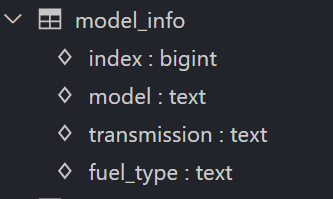

#### Second Table

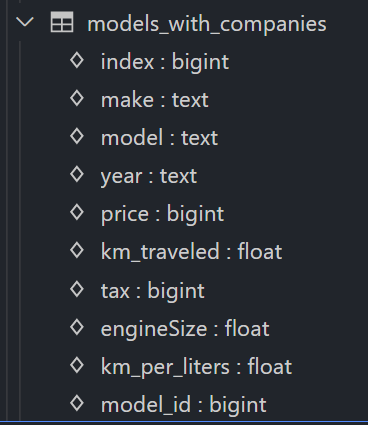

### According to the problem statement I am only selecting companies belonging to "Cheverolet"
Note: ON mc.model_id = mi."index" in this case "index" is in double quotes because index is a standard function or something in sqliete 
hence it is in double quotes

In [15]:
%%sql 
results << SELECT 
       year,
       price,
       km_traveled,
       tax,
       enginesize,
       km_per_liters,
       mi.model,
       transmission,
       fuel_type
FROM   models_with_companies mc
       INNER JOIN model_info mi
               ON mc.model_id = mi."index"
WHERE  make = 'Chevrolet'; 

 * sqlite:///car_prediction_dataset.sqlite3
Done.
Returning data to local variable results


In [16]:
# converting the results into a dataframe and dropping unimportant columns 
df = results.DataFrame()

## Method 2 to load data into pandas DataFrame using read_sql_query method of pandas

### Install required module
```
pip install SQLAlchemy
```

In [19]:
from sqlalchemy import create_engine 
engine = create_engine("sqlite:///car_prediction_dataset.sqlite3")

query = """
SELECT
       year,
       price,
       km_traveled,
       tax,
       enginesize,
       km_per_liters,
       mi.model,
       transmission,
       fuel_type
FROM   models_with_companies mc
       INNER JOIN model_info mi
               ON mc.model_id = mi."index"
WHERE  make = 'Chevrolet'; 
"""

In [20]:
df = pd.read_sql_query(query, con = engine,)

## 2.1 Training Machine Learning Model

In [21]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline


In [22]:
df.to_csv('car_price_data.csv')

#### Check for null values

In [23]:
df.isnull().sum()

year             0
price            0
km_traveled      0
tax              0
engineSize       0
km_per_liters    0
model            0
transmission     0
fuel_type        0
dtype: int64

#### Seperate the Dataset into dependent and independent

In [24]:
y = df['price']
X = df.drop('price', axis = 1)

In [25]:
X.dtypes

year              object
km_traveled      float64
tax                int64
engineSize       float64
km_per_liters    float64
model             object
transmission      object
fuel_type         object
dtype: object

### Divide Dataset into 3 parts Train, Test and Valid

In [26]:
X_train, X_test, y_train, y_test \
    = train_test_split(X, y, test_size=0.1, random_state=1)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train, y_train, test_size=0.1, random_state=1) 

In [27]:
X_train.shape, X_test.shape, X_valid.shape

((4131, 8), (511, 8), (459, 8))

## Note: we could simply take the whole dataset apply pd.dummies on unordered columns and convert ordered categorical columns into integers but I am not doing this because this is very bad practice because of.
1. We want to keep training, testing and validation datasets seperate 
2. What if new data comes we cannot use pd.dummies method to convert the new dataset 
3. using pd.dummies method is not scalable and probhits us from rapid developement of new models and testing

### Extracting names of numerical and categorical columns

In [28]:
numeric_columns = X.select_dtypes(exclude='object').columns
unordered_columns =['transmission', 'fuel_type']
# I am not one hot encoding year and model because there are too many values 
ordered_columns = ['year', 'model']

In [29]:
print(numeric_columns)
print(unordered_columns)
print(ordered_columns)

Index(['km_traveled', 'tax', 'engineSize', 'km_per_liters'], dtype='object')
['transmission', 'fuel_type']
['year', 'model']


### One Hot Encoding categorical columns

In [30]:
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
oh_cols_train = pd.DataFrame(oh_encoder.fit_transform(X_train[unordered_columns]))
oh_cols_valid = pd.DataFrame(oh_encoder.transform(X_valid[unordered_columns]))
# One-hot encoding removed index; put it back
oh_cols_train.index = X_train.index
oh_cols_valid.index = X_valid.index

### Lable Encoding ordered categorical columns 

In [31]:
ord_encoder = OrdinalEncoder()
ord_cols_train = pd.DataFrame(ord_encoder.fit_transform(X_train[ordered_columns]))
ord_cols_valid = pd.DataFrame(ord_encoder.transform(X_valid[ordered_columns]))
ord_cols_train.index = X_train.index
ord_cols_valid.index = X_valid.index


### Scaling Numerical Colummns 

In [32]:
# Remove categorical columns (will replace with one-hot encoding)
sc = StandardScaler()
sc_cols_train = pd.DataFrame(sc.fit_transform(X_train[numeric_columns]))
sc_cols_valid = pd.DataFrame(sc.transform(X_valid[numeric_columns]))
# One-hot encoding removed index; put it back
sc_cols_train.index = X_train.index
sc_cols_valid.index = X_valid.index

### Combining Numerical and Categorical Columns 

In [33]:
# Add one-hot encoded columns and numerical features
encoded_X_train = pd.concat([oh_cols_train, sc_cols_train,ord_cols_train], axis = 1)
encoded_X_valid = pd.concat([oh_cols_valid, sc_cols_valid,ord_cols_valid], axis = 1)


In [34]:
encoded_X_train

,0,1,2,3,4,5,6,7,0,1,2,3,0,1
146,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.563678,0.551531,0.766464,0.368858,10.0,14.0
4421,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.207064,-1.286746,0.766464,1.437213,22.0,41.0
249,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.107253,0.687700,0.077996,0.827622,24.0,41.0
4017,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.081205,0.687700,-1.069449,-0.265871,8.0,13.0
3414,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.804152,-1.286746,-1.069449,-0.341284,18.0,107.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4382,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.677210,0.551531,0.307485,-0.957160,6.0,13.0
3142,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.718917,0.755784,-1.069449,0.965880,5.0,118.0
4849,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.136860,-1.286746,-1.069449,-0.416698,13.0,92.0
1492,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.060286,-0.878240,0.766464,0.934458,24.0,119.0


### Converting above task into a function

In [35]:
def transform_columns(transformer,columns_to_transform,X_train = X_train,X_valid = X_valid,):
    cols_train =  pd.DataFrame(transformer.fit_transform(X_train[columns_to_transform]))
    cols_valid = pd.DataFrame(transformer.transform(X_valid[columns_to_transform]))
    cols_train.index = X_train.index
    cols_valid.index = X_valid.index
    return cols_train, cols_valid

In [36]:
columns_to_transform_list = [ordered_columns, unordered_columns, numeric_columns]
ordinal_encoder = OrdinalEncoder()
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
standard_scaler = StandardScaler()
transformers = [ordinal_encoder, onehot_encoder, standard_scaler]
encoded_train = []
encoded_validation = []
for columns_to_transform, transformer in zip(columns_to_transform_list, transformers):
    print(columns_to_transform)
    cols_train, cols_valid = transform_columns(transformer, columns_to_transform)
    #print(cols_train)
    encoded_train.append(cols_train)
    encoded_validation.append(cols_valid)
encoded_X_train = pd.concat(encoded_train, axis = 1)
encoded_X_valid = pd.concat(encoded_validation, axis = 1)
    

['year', 'model']
['transmission', 'fuel_type']
Index(['km_traveled', 'tax', 'engineSize', 'km_per_liters'], dtype='object')


### Checking base model with Linear regression
#### Performance is above the margin of error so not accepted

In [37]:
### Function to test various models
def score_dataset(X_train,X_valid,y_train,y_valid, input_model):
    model = input_model
    model.fit(X_train,y_train)
    preds = model.predict(X_valid)
    return np.sqrt(mean_squared_error(y_valid, preds))

In [38]:
input_model = LinearRegression()
score_dataset(encoded_X_train,encoded_X_valid,y_train,y_valid, input_model)

6461.622027825493

In [39]:
from sklearn.ensemble import RandomForestRegressor 
input_model = RandomForestRegressor()
score_dataset(encoded_X_train,encoded_X_valid,y_train,y_valid, input_model)

6713.889145247039

In [40]:
from sklearn.tree import DecisionTreeRegressor
input_model = DecisionTreeRegressor()
score_dataset(encoded_X_train,encoded_X_valid,y_train,y_valid, input_model)

10105.854018236583

In [41]:
from sklearn.svm import SVR
input_model = SVR()
score_dataset(encoded_X_train,encoded_X_valid,y_train,y_valid, input_model)

6756.349149847589

In [42]:
from sklearn.svm import LinearSVR
input_model = LinearSVR()
score_dataset(encoded_X_train,encoded_X_valid,y_train,y_valid, input_model)

7695.934283744947

In [43]:
from sklearn.ensemble import GradientBoostingRegressor
input_model = GradientBoostingRegressor()
score_dataset(encoded_X_train,encoded_X_valid,y_train,y_valid, input_model)

6612.090124611273

In [44]:
from sklearn.linear_model import ElasticNet
input_model = ElasticNet()
score_dataset(encoded_X_train,encoded_X_valid,y_train,y_valid, input_model)

6457.986587252211

## So the model performing best is ElasticNet and RandomForest
### GridSearch on ElasticNet

In [45]:
elastic_net_parag_grid =  {
                'alpha'     : [0.1,1,10,0.01,0.01,5],
                'l1_ratio'  :  np.arange(0.40,1.00,0.10),
            }
elastic_net_regressor = ElasticNet()
elastic_net_grid_search = GridSearchCV(
    elastic_net_regressor,
    param_grid=elastic_net_parag_grid,
    cv = 5,
    n_jobs=-1,
    verbose=1
)
elastic_net_grid_search.fit(encoded_X_train,y_train)
preds = elastic_net_grid_search.best_estimator_.predict(encoded_X_valid)
final_test_score = np.sqrt(mean_squared_error(y_valid, preds))

elastic_net_grid_search.best_params_


Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'alpha': 5, 'l1_ratio': 0.6}

### GridSearch on RandomForest

## So we kind of simplified the preprocessing but still there is too much code so, there is another method through which the whole process can be automated, We will be using Column transformer
1. There is also another disadvantage of above method first being we need to persist all 3 transformers and the model to load later.
2. The approach is not streamlined for rapid training.

https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

In [46]:
from sklearn import set_config

set_config(display="diagram")
numeric_columns = X.select_dtypes(exclude='object').columns
numeric_transformer = Pipeline(steps = [("scalar", StandardScaler())])

unordered_columns =['transmission', 'fuel_type']
unordered_transformer = Pipeline(steps = [('onehot',  OneHotEncoder(handle_unknown='ignore', sparse=False))])

ordered_columns = ['year', 'model']
ordered_transformer = Pipeline(steps = [('ordinal', OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_transformer', numeric_transformer, numeric_columns),
        ('unordered_transformer', unordered_transformer, unordered_columns),
        ('ordered_transformer', ordered_transformer, ordered_columns)
    ]
)

reg = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', ElasticNet())
    ]
)

In [47]:
y = df['price']
X = df.drop('price', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler())]),
                                                  Index(['km_traveled', 'tax', 'engineSize', 'km_per_liters'], dtype='object')),
                                                 ('unordered_transformer',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['transmission',
                                                   'fuel_type']),
                                                 ('ordered_transformer',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['year', 'model'])])),
                ('regressor', ElasticNet())])

In [48]:
preds = reg.predict(X_test)
score = np.sqrt(mean_squared_error(y_test, preds))

## using the above prediction pipeline in a grid search as we did above

In [49]:
param_grid = {
                'regressor__alpha': [0.1,1,10,0.01,0.01,5],
                'regressor__l1_ratio': np.arange(0.40,1.00,0.10),
            }

In [50]:
grid_search = GridSearchCV(reg, param_grid, cv=2)
grid_search


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric_transformer',
                                                                         Pipeline(steps=[('scalar',
                                                                                          StandardScaler())]),
                                                                         Index(['km_traveled', 'tax', 'engineSize', 'km_per_liters'], dtype='object')),
                                                                        ('unordered_transformer',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['transmission',
                                                                          'fuel_type']),
                                                                        ('ordered_transformer',
                                                                         Pipeline(steps=[('ordinal',
                                                                                          OrdinalEncoder())]),
                                                                         ['year',
                                                                          'model'])])),
                                       ('regressor', ElasticNet())]),
             param_grid={'regressor__alpha': [0.1, 1, 10, 0.01, 0.01, 5],
                         'regressor__l1_ratio': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9])})

In [51]:
grid_search.fit(X_train, y_train)
preds = grid_search.best_estimator_.predict(X_test)
score = np.sqrt(mean_squared_error(y_test, preds))

C:\Users\siddharth_black_pred\anaconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\siddharth_black_pred\anaconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\siddharth_black_pred\anaconda3\envs\geo_env\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\siddharth_black_pred\anaconda3\envs\geo_env\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Users\siddharth_black_pred\anaconda3\envs\geo_env\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)

## Saving the model

In [52]:
import joblib
# saving the model 
joblib.dump(grid_search.best_estimator_,'final_car_prediction_model.pkl')
# saving the column names 
joblib.dump(list(X.columns),'column_names.pkl')

['column_names.pkl']

## Loading the saved model


In [53]:
loaded_model = joblib.load('final_car_prediction_model.pkl')

## Making prediction on loaded model

In [54]:
loaded_model.predict(pd.DataFrame(data = [['2018', 39842.43038, 0, 1.5, 20.3643976, 'Camaro', 'Manual','Petrol']],
                                  columns = joblib.load('column_names.pkl')))

array([12693.99485813])

In [55]:
import joblib 
joblib.load('column_names.pkl')

['year',
 'km_traveled',
 'tax',
 'engineSize',
 'km_per_liters',
 'model',
 'transmission',
 'fuel_type']